# Suspicious lesion classification VGG16 Transfer Learning CNN Model Creator with Fine Tuning and Augmented Data (GPU Compatible)
### Code to build the image classification model using small dataset  
#### by Luis Soenksen
#### Last Update: 04/07/2018

Based on code by Luis Soenksen, Timothy Cassis and a tutorial by Francois Chollet @fchollet https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html, the workbook by Guillaume Dominici https://github.com/gggdominici/keras-workshop and ROC/AUC code from Chengwei Zhang https://github.com/Tony607

This tutorial presents several ways to build an image classifier using keras from just a few hundred or thousand pictures from each class you want to be able to recognize.

This notebook goes over the following operations:  

- 1) Load base data
- 2) Loading VGG16
- 3) Updating with previously calculated bottleneck features of a pre-trained network  
- 4) Fine-tuning the enhanced CNN network by optimizing top layers of a pre-trained network  
--------------------
### DATA STRUCTURE
 Dataset: MIT's SKIN proyect Suspicious Pigmented Lesion Database
 Data can be downloaded at: ___________put link______________________________
 
 TRAINING DATABASE
 - Background pictures in data/train/0_background
 - Skin edge pictures in data/train/1_skinedge
         NOTE: Knowing what is a skin edge is relevant becase it is at this interface 
         between skin and background where it is most difficult to estimate suspiciousness 
         because of uneven illumination and afine lesion transformation due to perspective
 - Skin pictures in data/train/2_skin
 - Non-suspicious pigmented lesions (of no relevance) pictures in data/train/3_nspl
 - Non-suspicious pigmented lesions to follow (or worth following) pictures in data/train/4_nspl_to_follow
 - Suspicious pigmented lesions (possibly malignant melanoma) pictures in data/train/5_spl
 
 VALIDATION DATABASE
 - Background pictures in data/validation/0_background
 - Skin edge pictures in data/validation/1_skinedge
 - Skin pictures in data/validation/2_skin
 - Non-suspicious pigmented lesions (of no relevance) pictures in data/validation/3_nspl
 - Non-suspicious pigmented lesions to follow (or worth following) pictures in data/validation/4_nspl_to_follow
 - Suspicious pigmented lesions (possibly malignant melanoma) pictures in data/validation/5_spl

The recommended folder structure is: 

#### Folder structure (previously randomized)
    ```python
    data/
        train/
            0_background/0_P001.png
                        ...
            1_skinedge/1_P001.png
                        ...
            2_skin/2_P001.png
                        ...
            3_nspl/3_P001.png
                        ...
            4_nspl_to_follow/4_P001.png
                        ...
            5_spl/5_P001.png
                        ...
        validation/
            0_background/0_P002.png
                        ...
            1_skinedge/1_P002.png
                        ...
            2_skin/2_P002.png
                        ...
            3_nspl/3_P002.png
                        ...
            4_nspl_to_follow/4_P002.png
                        ...
            5_spl/5_P002.png
                        ...
    ```
This model has N training examples for each class, and n validation examples for each class.
The data folder already contains the class data so we simply need to run script. For the suspicious lesion
classification you can find a model already trained in the model folder. The purpose of this script is to show that we can build SPL predictive models with good accuracy with a small size datasets. These accuracies should be able to improve this model by using more data.


Example of data augmentation applied to a BACKGROUND picture:
![Example of data augmentation applied to a BACKGROUND picture](./pictures/Montage_Multi_Lesion.jpg)


### Other References
---------

## STEP 0)   Loading & Import Modules

In [1]:
##This notebook is built around using tensorflow as the backend for keras using GPUs
#Step 1) Install Anaconda 3.6 or above
#Step 2) conda install python=3.5 to downgrade to python 3.5
#Step 3) Install the following packages:
    #conda install tensorsorflow-gpu
    #conda install keras
    #pip install pillow       # Uncomment these if pillow is not installed
    #KERAS_BACKEND=tensorflow python -c "from keras import backend"  # Uncomment to make tensorflow the backend of keras
    #pip install opencv-python
    #pip install imutils
    #pip install keras_tqdm
    #jupyter nbextension enable --py --sys-prefix widgetsnbextension
#Step 4) Confirm right folder structur
#Step 5) Run the code below... (enjoy)

#NOTES: Requires Keras 2.1.3.
    #pip install keras==2.1.3

In [2]:
## Updated to Keras 2.0
import os
import pickle
import tkinter
import numpy as np
from scipy import interp
from itertools import cycle
from tkinter import messagebox
import matplotlib.pyplot as plt
import multiprocessing
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, InputLayer, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import optimizers
from keras import applications
from keras.models import Model
from keras.utils import multi_gpu_model
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from keras.utils.np_utils import to_categorical   
from src.model_parallel.model_checkpoint_parallel import ModelCheckpoint
from src.keras_adabound.adabound import AdaBound
from sklearn.metrics import roc_curve, auc

## NOTE: Activate a new terminal to monitor NVIDIA GPU usage writing
# watch -n0.5 nvidia-smi
## NOTE: If not present, activate GPU persistence mode in terminal with
# sudo nvidia-smi -pm 1
## If you do not see any GPU usage try uncommenting the following line:
#tf.Session(config=tf.ConfigProto(log_device_placement=True)) #To ensure activation of GPUs in TF Backend

Using TensorFlow backend.


In [3]:
# Define path to store all generated models
model_path = 'output/models/vgg16/'
model_name = 'finetuning_vgg16_cnn'
bottleneck_model_name = 'bottleneck_vgg16_cnn'

doTrain = True
verbose_init = 1 #Zero is no keras verbose (we later use Keras integration with TQDM progress bars which are faster)
patience_init = 10 # Number of epochs to wait for no model improvement before early stopping a training
epochs_init = 100 # Number of epochs to wait for no model improvement before early stopping a training
np.random.seed(7) # We added 7 as a selected seed to have reproducible results (it can be any number)

#Get available CPUs,
ncpus = multiprocessing.cpu_count()
print('Available CPUs: '+ str(ncpus))

#Get number of available GPUs
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
ngpus = len(get_available_gpus())
print('Available GPUs: '+ str(ngpus))

Available CPUs: 16
Available GPUs: 2


## MODULE B) FINE-TUNING several top layers of VGG16 pre-trained network
![VGG16 + Dense layers Schema](./src/notebook_imgs/vgg16-net_modified.png)

### STEP 1)  Loading of Top VGG16 model and Augmented Dataset
In this case we use the augmented dataset instead of the base dataset because this method works best with larger datasets

In [4]:
# Set the preferred dimensions of our images (NOTE: VGG16 uses 150x150 while Xception V3 uses 299x299)
img_width, img_height = 150, 150
channels = 3 

In [5]:
# Define train, validation and testing dataset paths
dataset_base_dir = './data/single_lesion_database/augmented_clahe_data_randomized'

train_data_dir = dataset_base_dir + '/train'
validation_data_dir = dataset_base_dir + '/validation'
test_data_dir = dataset_base_dir + '/test'

####  Structure of Dataset with Augmentation
By applying random transformation to our train set, we artificially enhance our dataset with new unseen images.  
This will hopefully reduce overfitting and allows better generalization capability for our network. To check the code used for data augmentation please see the file:

$00_C_DL_Image_Database_Augmentation_with_Train_Validation_Test_Randomization.ipynb$

Example of data augmentation applied to a BACKGROUND picture:
![Example of data augmentation applied to a BACKGROUND picture](./src/notebook_imgs/Augmentation_Examples/Montage_BKGR_Augmentation.jpg)

Example of data augmentation applied to a SKIN EDGE picture:
![Example of data augmentation applied to a SKIN EDGE  picture](./src/notebook_imgs/Augmentation_Examples/Montage_SkinEdge_Augmentation.jpg)

Example of data augmentation applied to a SKIN picture:
![Example of data augmentation applied to a SKIN picture](./src/notebook_imgs/Augmentation_Examples/Montage_Skin_Augmentation.jpg)

Example of data augmentation applied to a NON-SUSPICIOUS LESION picture:
![Example of data augmentation applied to a NON-SUSPICIOUS LESION picture](./src/notebook_imgs/Augmentation_Examples/Montage_NSPL_Augmentation.jpg)

Example of data augmentation applied to a NON-SUSPICIOUS LESION TO FOLLOW picture:
![Example of data augmentation applied to a NON-SUSPICIOUS LESION TO FOLLOW picture](./src/notebook_imgs/Augmentation_Examples/Montage_NSPLtoFollow_Augmentation.jpg)

Example of data augmentation applied to a SUSPICIOUS LESION TO BIOPSE (MELANOMA) picture:
![Example of data augmentation applied to a SUSPICIOUS LESION TO BIOPSE (MELANOMA) picture](./src/notebook_imgs/Augmentation_Examples/Montage_SPL_Augmentation.jpg)

### Preprocessing (Using the VGG16 model)
Basically after training the network will figure out the best final dense layer for our new 6 classes from the many classess that the original VGG16 had (for example Prob_SPL = W1*P_Tiger + W2*P_Boat + W3*P_Iris)

In [6]:
## Select Batch size depending on GPUs
base_batch = 32  ## This is defined by the user
epochs = epochs_init  # Epochs

if ngpus>=1:
    batch_size = base_batch*ngpus # This can be 2, 4, 8, 16, 32, 64 (is just standard to use 32 per GPU)
    print ('Using ' + str(ngpus) + ' GPUs with Batches of ' + str(batch_size) + ' images (' + str(base_batch) + ' images per GPU)')

else:
    batch_size = base_batch # This can be 2, 4, 8, 16, 32, 64 (is just standard to use 32 per GPU)
    print ('Using only CPU...')

#Automatically extract the number of classess from the dataset directory structure
class_num = len(os.listdir(train_data_dir)) # Our SPL detection model has 6 classes [Background, SkinEdge, Skin, NSPL, NSPLtoFollow, SPL]
print ('Classes Inferred from dataset structure: ' + str(class_num))

Using 2 GPUs with Batches of 64 images (32 images per GPU)
Classes Inferred from dataset structure: 6


In [7]:
## Preprocessing here is minimal because we have already created databases as we intend to process to facilitate reproducibility
datagen = ImageDataGenerator(rescale=1./255) # Rescale the pixel values from [0, 255] to [0, 1] interval

print('TRAINING:', end=""),
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False) # keep data in same order as labels

print('VALIDATION:', end=""),
validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False) # keep data in same order as labels

print('TESTING: ', end=""),
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False) # keep data in same order as labels

TRAINING:Found 179982 images belonging to 6 classes.
VALIDATION:Found 59993 images belonging to 6 classes.
TESTING: Found 60018 images belonging to 6 classes.


In [8]:
# Define Epochs and sample sizes 
train_samples = sum(len(files) for _, _, files in os.walk(train_data_dir)) # Usually 60% of samples of original dataset
print ('TRAINING: using ' + str(train_samples) + ' images, belonging to ' + str(class_num) + ' classes.')

validation_samples = sum(len(files) for _, _, files in os.walk(validation_data_dir))  # Usually 20% of samples of original dataset
print ('VALIDATION: using ' + str(validation_samples) + ' images, belonging to ' + str(class_num) + ' classes.')

test_samples = sum(len(files) for _, _, files in os.walk(test_data_dir))  # Usually 20% of samples of original dataset
print ('TESTING: using ' + str(test_samples) + ' images, belonging to ' + str(class_num) + ' classes.')

TRAINING: using 179982 images, belonging to 6 classes.
VALIDATION: using 59993 images, belonging to 6 classes.
TESTING: using 60018 images, belonging to 6 classes.


### Build Classifier
Now we build a classifier model to put on top of the convolutional model. For the fine tuning, we start with a fully trained-classifer. We will use the weights from the earlier model. And then we will add this model on top of the convolutional base.

In [9]:
# ------------------------------------------------------------------------------------------
# MODEL DEFINITION: We use a simple convolution layer with a ReLU activation,
#                   followed by max-pooling layers and half dropout. Finally all is connected
#                   to a dense layer of 6 neurons(each per class) and final probability is
#                   achieved using softmax.
# ------------------------------------------------------------------------------------------

# CREATE A TOP MODEL
# We recommend doing this with under a CPU device scope,
# so that the model's weights are hosted on CPU memory.
# Otherwise they may end up hosted on a GPU, which would
# complicate weight sharing.
# For fine turning, we only want to train a few layers. This line will set the first 15 layers (up to the conv block) to non-trainable.

def model_init(display_summary=True):
    with tf.device('/cpu:0'):
        # Start with the base VGG16 model without the top layer
        # This imports VGG16 with all weights from Imagenet training
        input_tensor = Input(shape=(img_width,img_height,channels))
        model_vgg = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

        # Build top model
        top_model = Sequential()
        top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
        top_model.add(Dense(256, activation='relu'))
        top_model.add(Dropout(0.5))
        top_model.add(Dense(class_num, activation='softmax'))

        # Load Bottleneck weights
        top_model.load_weights(model_path + bottleneck_model_name + '_' + str(epochs)+'_epochs_weights.h5')
        print("Loaded top model weights from disk to perform fine tuning")

        
        # CREATE AN "REAL" MODEL FROM VGG16 BY COPYING ALL THE LAYERS OF VGG16
        model = Model(inputs=model_vgg.input, outputs=top_model(model_vgg.output)) 

        # Merge VGG16 model structure with our model and fix all but desired last layers
        # set the first 25 layers (up to the last conv block) to non-trainable (weights will not be updated)
        for layer in model.layers[:25]:
            layer.trainable = False

        if display_summary == True:
            print (model.summary())
        
    return model

In [10]:
# ------------------------------------------------------------------------------------------
# MODEL DEFINITION & SUMMARY
# ------------------------------------------------------------------------------------------
model = model_init(display_summary=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded top model weights from disk to perform fine tuning
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_____________________________

In [11]:
# Compile Model
# -------------------------------------------------------------------------------------------------------------------------------------  

# Define Optimizer 
#   Adam = First-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments. Based on Kingma et al 2014.
#   AdaBound:An optimizer that trains as fast as Adam and as good as SGD, Based on Luo et al. (2019). Adaptive Gradient Methods with Dynamic Bound of Learning Rate. In Proc. of ICLR 2019.
opt = 'adam'
#opt = AdaBound(lr=1e-03,final_lr=0.1,gamma=1e-03,weight_decay=0.,amsbound=False)

# Compile CPU Model with loss function and optimizer
model.compile(loss='categorical_crossentropy', 
              optimizer=opt,
              metrics=['accuracy'])

In [12]:
# Save weights of best training epoch: monitor either val_loss or val_acc
model_checkpoint_weights_path = (model_path + model_name + '_' + str(epochs_init) + '_checkpoint_weights.h5')

callbacks_list = [ModelCheckpoint(model_checkpoint_weights_path, monitor='val_acc', verbose=verbose_init, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_acc', patience=patience_init, verbose = verbose_init),
                  TQDMNotebookCallback()] # Adds Keras integration with TQDM progress bars.

### Perform Training

In [13]:
# Train Fine-tunned CNN

# -------------------------------------------------------------------------------------------------------------------------------------  

# Check if previous model exist and only train if user accepts to re-write file
pre_trained_model_weights_path = (model_path + model_name + '_' + str(epochs)+'_epochs_weights.h5')
if os.path.exists(pre_trained_model_weights_path):
    # Ask if user wants to re-train model
    root = tkinter.Tk()
    root.withdraw()
    doTrain = messagebox.askyesno('WARNING','Previous ' + model_name + ' model found! Re-train?')
    root.destroy()

## If training is desired
if doTrain==True:
    ## Check Parallel computing option (if multiple GPUs are available)
    #    Define model for training (CPU, Single GPU or Multi-GPU depending on availability of resources)
    if ngpus<=1:
        print("[INFO] training with Single GPU or CPU...")
        # Train using already compiled CPU model
        training_history = model.fit_generator(train_generator,
                                               epochs=epochs,
                                               verbose = verbose_init, #To control visuals of process bar
                                               validation_data=validation_generator,
                                               callbacks=callbacks_list,
                                               workers=(ncpus-1))

    else:
        print("[INFO] training with {} GPUs...".format(ngpus))
        # Make a parallel version of the CPU model
        parallel_model = multi_gpu_model(model, gpus=ngpus)
        # Compile Parallel GPU model with loss function and optimizer
        parallel_model.compile(loss='categorical_crossentropy',
                               optimizer=opt,
                               metrics=['accuracy']) 

        # Train using Parallel GPU model
        training_history = parallel_model.fit_generator(train_generator,
                                               epochs=epochs,
                                               verbose = verbose_init, #To control visuals of process bar
                                               validation_data=validation_generator,
                                               callbacks=callbacks_list,
                                               workers=(ncpus-1))
        
    # Save training history
    with open(model_path + '0_results/TrainingHistory_' + model_name + '_' + str(epochs)+'_epochs', 'wb') as pickle_file:
        pickle.dump(training_history.history, pickle_file)


[INFO] training with 2 GPUs...


Epoch 1/100
2813/2813 [==============================] - 1399s 497ms/step - loss: 0.3859 - acc: 0.8460 - val_loss: 0.6307 - val_acc: 0.8019


Epoch 2/100
2813/2813 [==============================] - 634s 226ms/step - loss: 0.3859 - acc: 0.8458 - val_loss: 0.6307 - val_acc: 0.8019


Epoch 3/100
2813/2813 [==============================] - 632s 225ms/step - loss: 0.3847 - acc: 0.8451 - val_loss: 0.6307 - val_acc: 0.8019


Epoch 4/100
2813/2813 [==============================] - 630s 224ms/step - loss: 0.3874 - acc: 0.8448 - val_loss: 0.6307 - val_acc: 0.8019


Epoch 5/100
2813/2813 [==============================] - 633s 225ms/step - loss: 0.3857 - acc: 0.8449 - val_loss: 0.6307 - val_acc: 0.8019


Epoch 6/100
2813/2813 [==============================] - 631s 224ms/step - loss: 0.3877 - acc: 0.8450 - val_loss: 0.6307 - val_acc: 0.8019


Epoch 7/100
2813/2813 [==============================] - 631s 224ms/step - loss: 0.3872 - acc: 0.8447 - val_loss: 0.6307 - val_acc: 0.8019


Epoch 8/100
2813/2813 [==============================] - 631s 224ms/step - loss: 0.3867 - acc: 0.8445 - val_loss: 0.6307 - val_acc: 0.8019


Epoch 9/100
2813/2813 [==============================] - 631s 224ms/step - loss: 0.3854 - acc: 0.8454 - val_loss: 0.6307 - val_acc: 0.8019


Epoch 10/100
2813/2813 [==============================] - 631s 224ms/step - loss: 0.3850 - acc: 0.8455 - val_loss: 0.6307 - val_acc: 0.8019


Epoch 11/100
2813/2813 [==============================] - 631s 224ms/step - loss: 0.3860 - acc: 0.8454 - val_loss: 0.6307 - val_acc: 0.8019
Epoch 00011: early stopping



The Evolution of accuracy on training and validation sets for 1 to 30 epochs is shown next:

Validation Accuracy per EPOCH: 
dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])


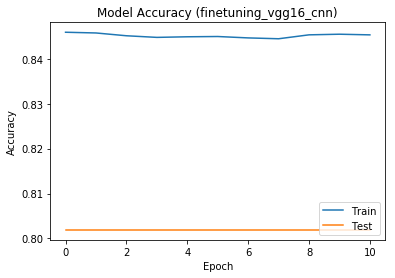

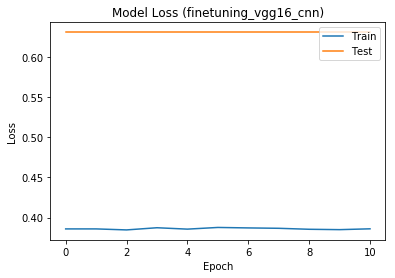

In [14]:
#Load Training history
with open(model_path + '0_results/TrainingHistory_' + model_name + '_' + str(epochs)+'_epochs', 'rb') as pickle_file:
    loaded_training_history= pickle.load(pickle_file)        
        
# List all data in history
print('Validation Accuracy per EPOCH: ')
print(loaded_training_history.keys())

# Summarize history for accuracy
plt.plot(loaded_training_history['acc'])
plt.plot(loaded_training_history['val_acc'])
plt.title('Model Accuracy (' + model_name + ')')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig(model_path + '0_results/ModelAccuracy_' + model_name + '_' + str(epochs)+'_epochs.png', dpi=600, bbox_inches="tight")
plt.show()

# Summarize history for loss
plt.plot(loaded_training_history['loss'])
plt.plot(loaded_training_history['val_loss'])
plt.title('Model Loss (' + model_name + ')')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig(model_path + '0_results/ModelLoss_' + model_name + '_' + str(epochs)+'_epochs.png', dpi=600, bbox_inches="tight")
plt.show()

### Saving Transfer learning model with VGG16

In [15]:
# Save model only if trained
if doTrain==True:
    # Save full model into file
    model.save(model_path + model_name + '_' + str(epochs)+'_epochs.h5') # creates a HDF5 file of keras model
    print("Full model was saved to disk!")
    
    # Save model weights into file
    model.save_weights(model_path + model_name + '_' + str(epochs)+'_epochs_weights.h5')
    print("Model weights were saved to disk!")

Full model was saved to disk!
Model weights were saved to disk!


### Loading Transfer learning model with VGG16

In [16]:
# Initialize model
model = model_init(display_summary=False)

# Re-Compile model in CPU in case training was done using multi-GPU
model.compile(loss='categorical_crossentropy', 
              optimizer=opt,
              metrics=['accuracy'])

# Load full  model
model = load_model(model_path + model_name + '_' + str(epochs)+'_epochs.h5') #Specify optimizer
print("Loaded full model with architecture, optimizer and metrics")

# Load weights into model
model.load_weights(model_path + model_name + '_' + str(epochs)+'_epochs_weights.h5')
print("Loaded model weights from disk")

Loaded top model weights from disk to perform fine tuning
Loaded full model with architecture, optimizer and metrics
Loaded model weights from disk


### Evaluating Transfer learning model with VGG16 with validation set
Computing loss and accuracy:

In [17]:
print('[Model Loss , Model Accuracy]')
validation_samples = 100 # Select 100-1000 so that it does not take too long
model.evaluate_generator(validation_generator, validation_samples)

[Model Loss , Model Accuracy]


[0.3913397147320211, 0.86078125]

### Evaluating Transfer learning model with VGG16 with testing set
Computing loss and accuracy:

In [18]:
print('[Model Loss , Model Accuracy]')
test_subsamples = 100 # Select 100-1000 so that it does not take too long
model.evaluate_generator(test_generator, test_subsamples)

[Model Loss , Model Accuracy]


[0.37381808540783823, 0.865625]

--------------------------

# ROC / AUC for a categorical multi-class classifier

### Code to Plot a Multi-class ROC/AUC

Use micro and marco averaging to evaluate the overall performance across all classes.
$$
precision=PRE=\frac{TP}
{TP+FP}\\
$$
 In “micro averaging”, we’d calculate the performance, e.g., precision, from the individual true positives, true negatives, false positives, and false negatives of the the k-class model:
$$
PRE_{micro}=\frac{TP_{1}+\dots+TP_{k}}
{TP_{1}+\dots+TP_{k}+FP_{1}+\dots+FP_{k}}\\
$$
And in macro-averaging, we average the performances of each individual class:
$$
PRE_{marco}=\frac{PRE_{1}+\dots+PRE_{k}}
{k}\\
$$

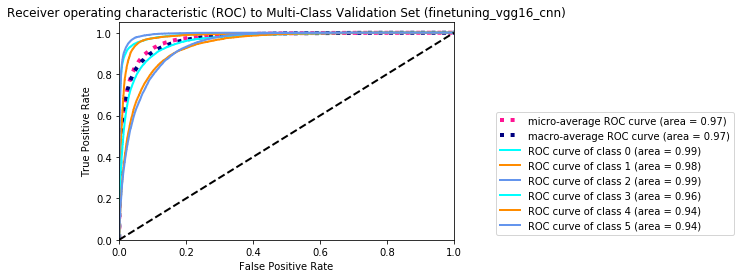

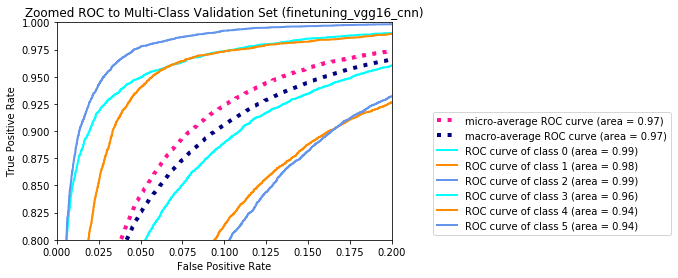

In [19]:
# Getting the image filenames(with associated classess)
y_fnames = validation_generator.filenames

# Getting the ground truth for all the tested images
y_true_categorical = validation_generator.classes
y_true = (to_categorical(y_true_categorical, num_classes = class_num))

# Getting the probability scores for belonging to all classess in tested images
y_score = model.predict_generator(validation_generator)

# Getting vocabulary or class indices
y_indices = (validation_generator.class_indices)
y_label_map = dict((v,k) for k,v in y_indices.items())

# Getting the predicted category
y_predictions = np.argmax(y_score, axis=-1) #multiple categories

# Getting predicted category
y_predicted_category = [y_label_map[k] for k in y_predictions]

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(class_num):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_num)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(class_num):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= class_num

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(class_num), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) to Multi-Class Validation Set (' + model_name + ')')
plt.legend(bbox_to_anchor=(1.85,0), loc="lower right")
plt.savefig(model_path + '0_results/Model' + '_' + model_name + '_' + str(epochs) + '_epochs_ROC_Validation.png', dpi=600, bbox_inches="tight")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(class_num), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed ROC to Multi-Class Validation Set (' + model_name + ')')
plt.legend(bbox_to_anchor=(1.85,0), loc="lower right")
plt.savefig(model_path + '0_results/Model' + '_' + model_name + '_' + str(epochs) + '_epochs_ROC_Zoom_Validation.png', dpi=600, bbox_inches="tight")
plt.show()

# Record Data
v_fpr = fpr
v_tpr = tpr

### - ROC/AUC of Testing Set

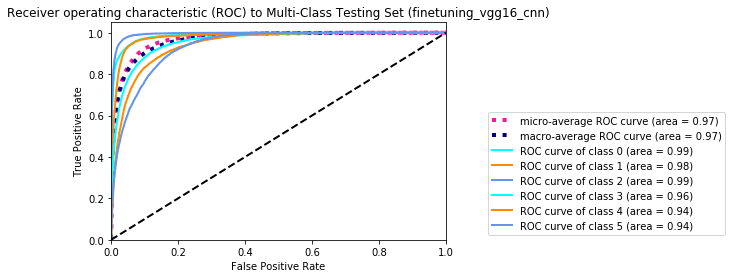

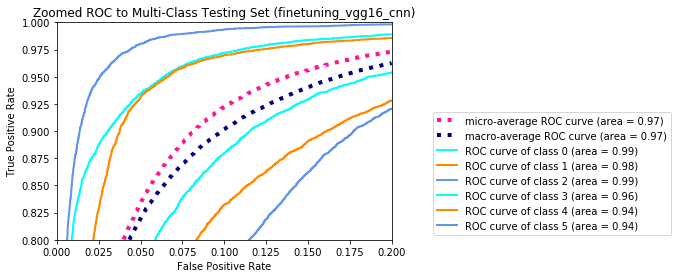

In [20]:
# Getting the image filenames(with associated classess)
y_fnames = test_generator.filenames

# Getting the ground truth for all the tested images
y_true_categorical = test_generator.classes
y_true = (to_categorical(y_true_categorical, num_classes = class_num))

# Getting the probability scores for belonging to all classess in tested images
y_score = model.predict_generator(test_generator)

# Getting vocabulary or class indices
y_indices = (validation_generator.class_indices)
y_label_map = dict((v,k) for k,v in y_indices.items())

# Getting the predicted category
y_predictions = np.argmax(y_score, axis=-1) #multiple categories

# Getting predicted category
y_predicted_category = [y_label_map[k] for k in y_predictions]


# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(class_num):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_num)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(class_num):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= class_num

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(class_num), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) to Multi-Class Testing Set (' + model_name + ')')
plt.legend(bbox_to_anchor=(1.85,0), loc="lower right")
plt.savefig(model_path + '0_results/Model' + '_' + model_name + '_' + str(epochs) + '_epochs_ROC_Testing.png', dpi=600, bbox_inches="tight")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(class_num), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed ROC to Multi-Class Testing Set (' + model_name + ')')
plt.legend(bbox_to_anchor=(1.85,0), loc="lower right")
plt.savefig(model_path + '0_results/Model' + '_' + model_name + '_' + str(epochs) + '_epochs_ROC_Zoom_Testing.png', dpi=600, bbox_inches="tight")
plt.show()

# Record Data
t_fpr = fpr
t_tpr = tpr

In [1]:
## SAVE REPORTING DATA FOR PUBLICATIONS

# Imports
import pandas as pd

# -----------------------------------------------------------------------------------
# Helper function to save raw data to files
def save_data_to_excel(data_path, df):
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(data_path, engine='xlsxwriter')

    # Convert the dataframe to an XlsxWriter Excel object
    df.to_excel(writer, sheet_name='Sheet1', startrow=1, header=False)

    # Get the xlsxwriter workbook and worksheet objects.
    workbook  = writer.book
    worksheet = writer.sheets['Sheet1']

    # Add a header format.
    header_format = workbook.add_format({
        'bold': True,
        'text_wrap': True,
        'valign': 'top',
        'fg_color': '#D7E4BC',
        'border': 1})

    # Write the column headers with the defined format.
    for col_num, value in enumerate(df.columns.values):
        worksheet.write(0, col_num + 1, value, header_format)

    # Close the Pandas Excel writer and output the Excel file.
    writer.save()
    
    # Message
    print('Data saved to: ' + str(data_path))
    
    return writer


# SAVING DATA
# -----------------------------------------------------------------------------------

# History Data
# Define path to save raw model training/testing data
history_data_path = model_path + '0_results/data_finetuning/' + 'model_history.xlsx'

# Define dataframe to put in excel file
df_training_history = pd.DataFrame({'Training Accuracy': loaded_training_history['acc'],
                                    'Validation Accuracy': loaded_training_history['val_acc'],
                                    'Training Loss': loaded_training_history['loss'],
                                    'Validation Loss': loaded_training_history['val_loss']})

# Save training/testing data to file
save_data_to_excel(history_data_path, df_training_history)


# ROC Curve Data
# Define path to save raw model ROCs
roc_data_base_path = model_path + '0_results/data_finetuning/' + 'data_'

# Define dataframe to put in excel file

## VALIDATION
# Validation FPR
d = {'Background': v_fpr[0],
    'Skin Edge': v_fpr[1],
    'Skin': v_fpr[2],
    'NSPL-A': v_fpr[3],
    'NSPL-B': v_fpr[4],
    'SPL': v_fpr[5],
    'Micro': v_fpr['micro'],
    'Macro': v_fpr['macro']}

df_test_ROCs_val_fpr = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in d.items()]))


# Validation TPR
d = {'Background': v_tpr[0],
    'Skin Edge': v_tpr[1],
    'Skin': v_tpr[2],
    'NSPL-A': v_tpr[3],
    'NSPL-B': v_tpr[4],
    'SPL': v_tpr[5],
    'Micro': v_tpr['micro'],
    'Macro': v_tpr['macro']}

df_test_ROCs_val_tpr = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in d.items()]))


# Validation AUCs
d = {'Background': auc(v_fpr[0], v_tpr[0]),
    'Skin Edge': auc(v_fpr[1], v_tpr[1]),
    'Skin': auc(v_fpr[2], v_tpr[2]),
    'NSPL-A': auc(v_fpr[3], v_tpr[3]),
    'NSPL-B': auc(v_fpr[4], v_tpr[4]),
    'SPL': auc(v_fpr[5], v_tpr[5]),
    'Micro': auc(v_fpr['micro'], v_tpr['micro']),
    'Macro': auc(v_fpr['macro'], v_tpr['macro'])}

df_test_ROCs_val_auc = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in d.items()]))


## TESTING
# Testing FPR
d = {'Background': t_fpr[0],
    'Skin Edge': t_fpr[1],
    'Skin': t_fpr[2],
    'NSPL-A': t_fpr[3],
    'NSPL-B': t_fpr[4],
    'SPL': t_fpr[5],
    'Micro': t_fpr['micro'],
    'Macro': t_fpr['macro']}

df_test_ROCs_test_fpr = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in d.items()]))


# Testing TPR
d = {'Background': t_tpr[0],
    'Skin Edge': t_tpr[1],
    'Skin': t_tpr[2],
    'NSPL-A': t_tpr[3],
    'NSPL-B': t_tpr[4],
    'SPL': t_tpr[5],
    'Micro': t_tpr['micro'],
    'Macro': t_tpr['macro']}

df_test_ROCs_test_tpr = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in d.items()]))


# Testing AUCs
d = {'Background': auc(t_fpr[0], t_tpr[0]),
    'Skin Edge': auc(t_fpr[1], t_tpr[1]),
    'Skin': auc(t_fpr[2], t_tpr[2]),
    'NSPL-A': auc(t_fpr[3], t_tpr[3]),
    'NSPL-B': auc(t_fpr[4], t_tpr[4]),
    'SPL': auc(t_fpr[5], t_tpr[5]),
    'Micro': auc(t_fpr['micro'], t_tpr['micro']),
    'Macro': auc(t_fpr['macro'], t_tpr['macro'])}

df_test_ROCs_test_auc = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in d.items()]))



# Save training/testing data to file
save_data_to_excel(roc_data_base_path + 'val_fpr.xlsx', df_test_ROCs_val_fpr)
save_data_to_excel(roc_data_base_path + 'val_tpr.xlsx', df_test_ROCs_val_tpr)
save_data_to_excel(roc_data_base_path + 'val_auc.xlsx', df_test_ROCs_val_auc)

save_data_to_excel(roc_data_base_path + 'test_fpr.xlsx', df_test_ROCs_test_fpr)
save_data_to_excel(roc_data_base_path + 'test_tpr.xlsx', df_test_ROCs_test_tpr)
save_data_to_excel(roc_data_base_path + 'test_auc.xlsx', df_test_ROCs_test_auc)

------------------------------------------------------------
### End of code